In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles
!gsutil cp -r gs://gresearch/goemotions/data/full_dataset/ .

/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles
Copying gs://gresearch/goemotions/data/full_dataset/goemotions_1.csv...
Copying gs://gresearch/goemotions/data/full_dataset/goemotions_2.csv...
Copying gs://gresearch/goemotions/data/full_dataset/goemotions_3.csv...
\ [3 files][ 40.8 MiB/ 40.8 MiB]                                                
Operation completed over 3 objects/40.8 MiB.                                     


In [3]:
# Installing additional libraries for text preprocessing
!pip install -q preprocessor
!pip install -q contractions
!pip install emoji

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 5.1 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Text processing libraries
import emoji
import string
import re
import preprocessor
import contractions
from collections import Counter
import spacy
from spacy.lang.en.stop_words import STOP_WORDS


from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)

tqdm.pandas()

from wordcloud import WordCloud
from IPython.display import Image
from PIL import Image




In [5]:
# Importing train, validation and test datasets with preprocessed texts and labels
ds1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/goemotions_1.csv")
ds2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/goemotions_2.csv")
ds3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/goemotions_3.csv")

# Shape validation
print(ds1.shape)
print(ds2.shape)
print(ds3.shape)

(70000, 37)
(70000, 37)
(71225, 37)


In [6]:
df = pd.concat([ds1, ds2, ds3], axis=0)
df.reset_index(drop=True, inplace=True)

In [7]:
df

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,Everyone likes [NAME].,ee6pagw,Senshado,heroesofthestorm,t3_agjf24,t3_agjf24,1.547634e+09,16,False,0,...,1,0,0,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,ef28nod,5inchloser,nottheonion,t3_ak26t3,t3_ak26t3,1.548553e+09,15,False,0,...,0,0,0,0,0,0,0,0,0,0
211222,That looks amazing,ee8hse1,springt1me,shittyfoodporn,t3_agrnqb,t3_agrnqb,1.547684e+09,70,False,1,...,0,0,0,0,0,0,0,0,0,0
211223,The FDA has plenty to criticize. But like here...,edrhoxh,enamedata,medicine,t3_aejqzd,t1_edrgdtx,1.547169e+09,4,False,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
emotions = set(df.columns[9:])
emotions

{'admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'neutral',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise'}

In [9]:
df.shape

(211225, 37)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  

In [11]:
df.columns

Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [12]:
df.isna().any()

text                    False
id                      False
author                  False
subreddit               False
link_id                 False
parent_id               False
created_utc             False
rater_id                False
example_very_unclear    False
admiration              False
amusement               False
anger                   False
annoyance               False
approval                False
caring                  False
confusion               False
curiosity               False
desire                  False
disappointment          False
disapproval             False
disgust                 False
embarrassment           False
excitement              False
fear                    False
gratitude               False
grief                   False
joy                     False
love                    False
nervousness             False
optimism                False
pride                   False
realization             False
relief                  False
remorse   

In [13]:
df.isnull().sum().reset_index()

,index,0
0,text,0
1,id,0
2,author,0
3,subreddit,0
4,link_id,0
5,parent_id,0
6,created_utc,0
7,rater_id,0
8,example_very_unclear,0
9,admiration,0


In [14]:
df.describe()

,created_utc,rater_id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
count,2.112250e+05,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,...,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000
mean,1.547659e+09,37.619742,0.081103,0.043768,0.038272,0.064472,0.083418,0.028401,0.034840,0.045885,...,0.038779,0.008569,0.041259,0.006164,0.041591,0.006102,0.011954,0.031994,0.026105,0.261797
std,7.696842e+05,23.070528,0.272994,0.204580,0.191853,0.245592,0.276514,0.166116,0.183374,0.209236,...,0.193067,0.092172,0.198890,0.078269,0.199653,0.077880,0.108679,0.175985,0.159448,0.439614
min,1.546301e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.546993e+09,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.547664e+09,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.548320e+09,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.548979e+09,81.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df['text'].count()

211225

In [16]:
df['text'].unique()

array(['That game hurt.',
       ' >sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of "grouping" ',
       "You do right, if you don't care then fuck 'em!", ...,
       'Thanks, [NAME]', 'Everyone likes [NAME].',
       'I just called the Capitol Police. They are not affected by the shutdown. [NAME] is fucking full of shit.'],
      dtype=object)

In [17]:
positive = {'admiration','amusement','approval','caring','desire','excitement','gratitude','joy','love','optimism','pride','relief'}
negative = {'sadness','fear','embarrassment','disapproval','disappointment','annoyance','anger','nervousness','remorse','grief','disgust'}
ambiguous = {'realization','surprise','curiosity','confusion','neutral'}

print(f'Fine grained emotions: {len(emotions)}')
print(f'Number of data: {len(df)}')
print(f'Number of positive emotions: {len(positive)}')
print(f'Number of negative emotions: {len(negative)}')
print(f'Number of ambiguous emotions: {len(ambiguous)}')

Fine grained emotions: 28
Number of data: 211225
Number of positive emotions: 12
Number of negative emotions: 11
Number of ambiguous emotions: 5


In [18]:
df_emotion = pd.DataFrame()
df_emotion['emotion'] = list(emotions)
df_emotion['group'] = ''
df_emotion['group'].loc[df_emotion['emotion'].isin(positive)] = 'positive'
df_emotion['group'].loc[df_emotion['emotion'].isin(negative)] = 'negative'
df_emotion['group'].loc[df_emotion['emotion'].isin(ambiguous)] = 'ambiguous'
df_emotion

,emotion,group
0,joy,positive
1,amusement,positive
2,caring,positive
3,realization,ambiguous
4,disgust,negative
5,neutral,ambiguous
6,surprise,ambiguous
7,disapproval,negative
8,optimism,positive
9,relief,positive


In [19]:
emotions_list = list(emotions)

<Axes: xlabel='n', ylabel='emotion'>

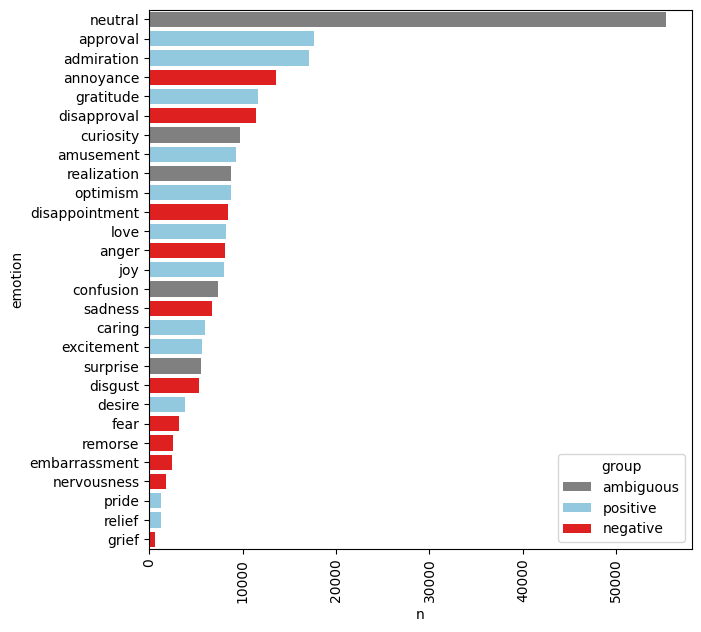

In [20]:
temp = df[list(emotions)].sum(axis=0) \
    .reset_index() \
    .rename(columns={'index': 'emotion', 0: 'n'}) \
    .merge(df_emotion, how='left', on='emotion')\
    .sort_values('n', ascending=False)

fig, ax = plt.subplots(figsize=(7, 7))
ax.tick_params(axis='x', rotation=90)
palette ={
    "positive": "skyblue",
    "negative": "red",
    "ambiguous": 'gray'
}
sns.barplot(data=temp, x='n',
            y='emotion', hue='group',
            dodge=False,
            palette=palette,
            ax=ax)

<Axes: xlabel='group', ylabel='n'>

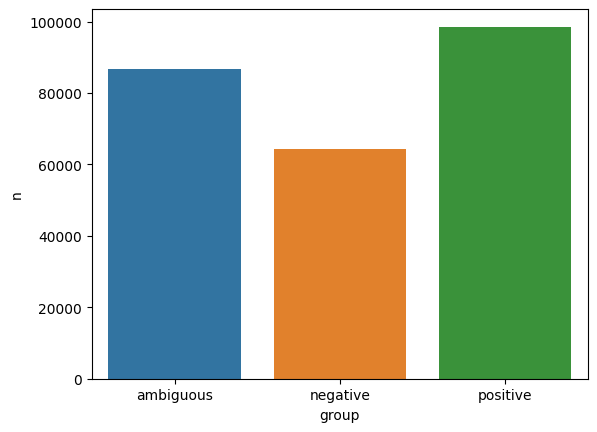

In [21]:
temp = temp.groupby('group') \
        .agg('sum').reset_index()

sns.barplot(data=temp, x='group', y='n', hue='group')

In [22]:
df_emotion.columns

Index(['emotion', 'group'], dtype='object')

<Axes: xlabel='emotion', ylabel='true positive rate'>

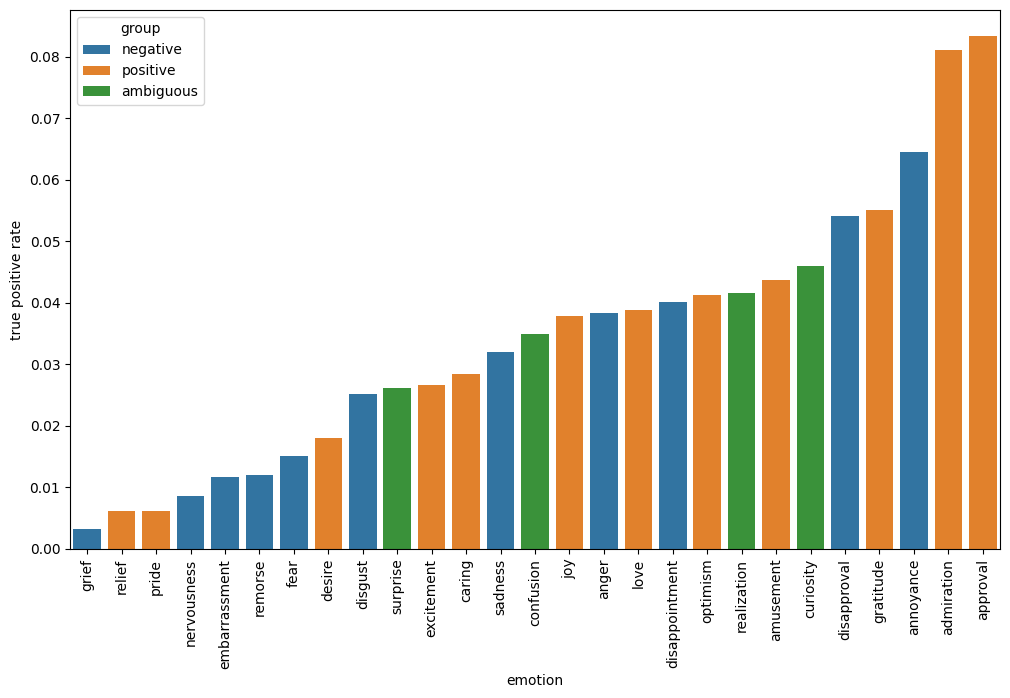

In [23]:
temp = pd.DataFrame()
temp['true positive rate'] = df.iloc[:, 9:-1].mean(0)
temp['emotion'] = df.columns[9:-1]
temp = temp.merge(df_emotion, how='left', on='emotion')
temp = temp.sort_values('true positive rate')

fig, ax = plt.subplots(figsize=(12, 7))
ax.tick_params(axis='x', rotation=90)

sns.barplot(x=temp['emotion'],
            y=temp['true positive rate'],
            hue=temp['group'],
            dodge=False)

In [24]:
df1 =df['example_very_unclear'].value_counts()

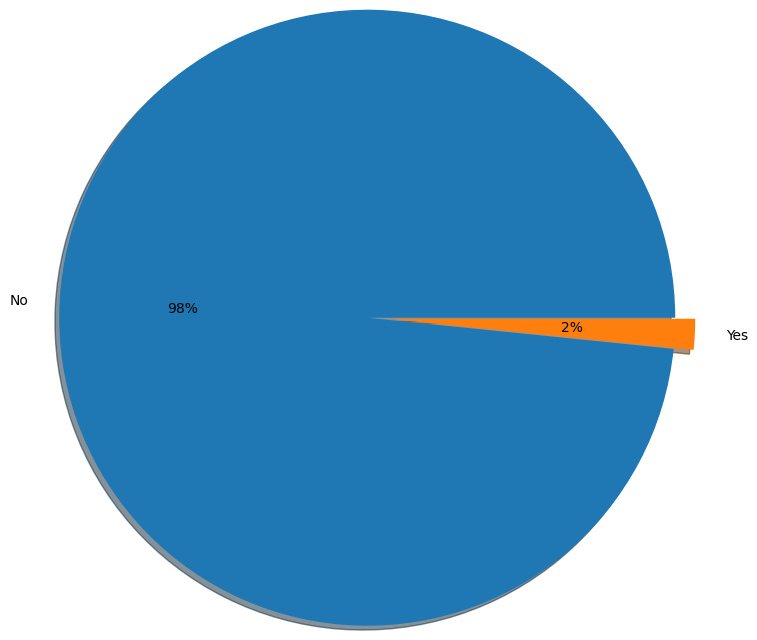

In [25]:
plt.figure(figsize = (5,5))
plt.pie(df1,labels = ['No','Yes'],autopct='%.0f%%' , radius = 2 ,explode = (0.1,0.03),shadow = True)
plt.show()

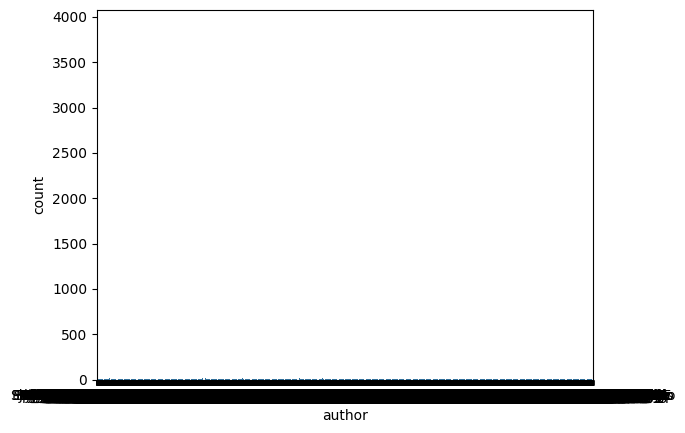

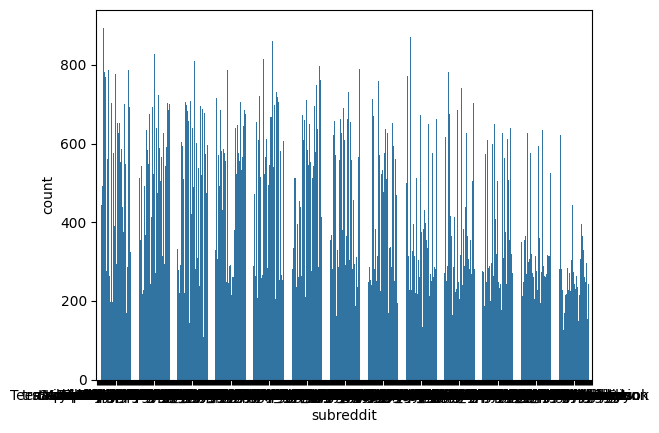

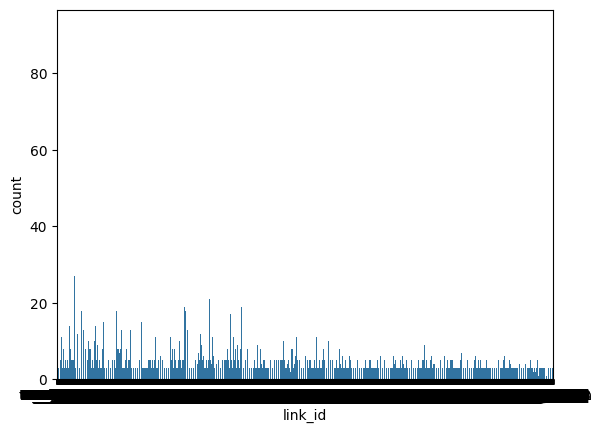

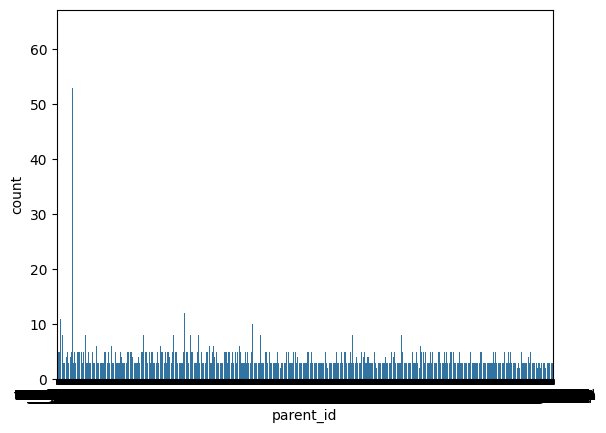

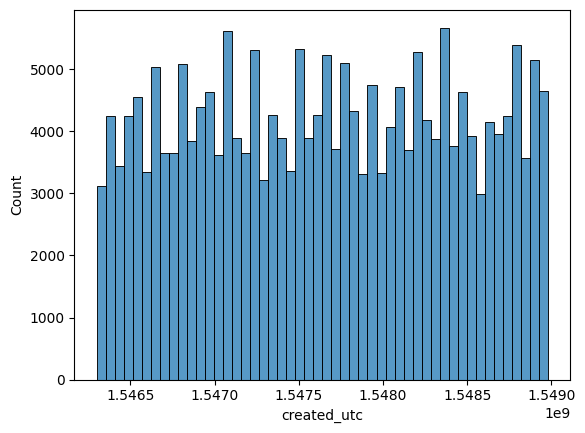

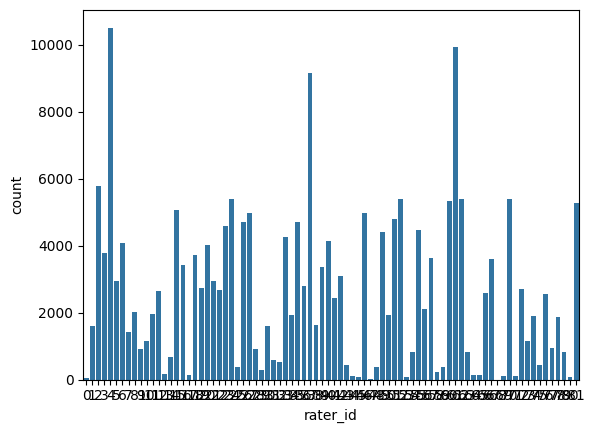

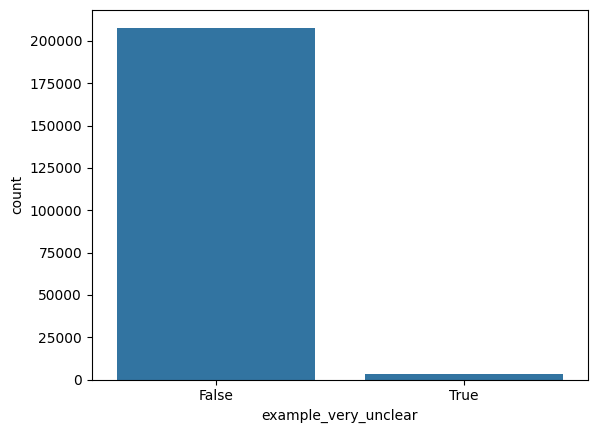

In [26]:
# Visualize the distribution of authors
sns.countplot(x='author', data=df)
plt.show()

# Visualize the distribution of subreddits
sns.countplot(x='subreddit', data=df)
plt.show()

# Visualize the distribution of link IDs
sns.countplot(x='link_id', data=df)
plt.show()

# Visualize the distribution of parent IDs
sns.countplot(x='parent_id', data=df)
plt.show()

# Visualize the distribution of created UTC timestamps
sns.histplot(x='created_utc', data=df, bins=50)
plt.show()

# Visualize the distribution of rater IDs
sns.countplot(x='rater_id', data=df)
plt.show()

# Visualize the distribution of example very unclear labels
sns.countplot(x='example_very_unclear', data=df)
plt.show()

In [27]:
# List of columns to drop
columns_to_drop = ['author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id','id',	'example_very_unclear']

# Dropping the columns
df = df.drop(columns=columns_to_drop)

In [28]:
df

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,Everyone likes [NAME].,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211222,That looks amazing,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,The FDA has plenty to criticize. But like here...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Function for cleaning text
def preprocess_corpus(text):

    # Adding a space between words and punctation
  x = re.sub( r'([a-zA-Z\[\]])([,;.!?])', r'\1 \2', text)
  x = re.sub( r'([,;.!?])([a-zA-Z\[\]])', r'\1 \2', text)
    # Demojize
  x = emoji.demojize(text)

  re_number = re.compile('[0-9]+')
  re_url = re.compile("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
  re_tag = re.compile('\[[A-Z]+\]')
  re_char = re.compile('[^0-9a-zA-Z\s?!.,:\'\"//]+')
  re_char_clean = re.compile('[^0-9a-zA-Z\s?!.,\[\]]')
  re_punc = re.compile('[?!,.\'\"]')

  text = re.sub(re_char, "", text) # Remove unknown character
  text = contractions.fix(text) # Expand contraction
  text = re.sub(re_url, ' [url] ', text) # Replace URL with number
  text = re.sub(re_char_clean, "", text) # Only alphanumeric and punctuations.
  #text = re.sub(re_punc, "", text) # Remove punctuation.
  text = text.lower() # Lower text
   ####
  # Correct some acronyms/typos/abbreviations
  text = re.sub(r"lmao", "laughing my ass off", text)
  text = re.sub(r"amirite", "am i right", text)
  text = re.sub(r"\b(tho)\b", "though", text)
  text = re.sub(r"\b(ikr)\b", "i know right", text)
  text = re.sub(r"\b(ya|u)\b", "you", text)
  text = re.sub(r"\b(eu)\b", "europe", text)
  text = re.sub(r"\b(da)\b", "the", text)
  text = re.sub(r"\b(dat)\b", "that", text)
  text = re.sub(r"\b(dats)\b", "that is", text)
  text = re.sub(r"\b(cuz)\b", "because", text)
  text = re.sub(r"\b(fkn)\b", "fucking", text)
  text = re.sub(r"\b(tbh)\b", "to be honest", text)
  text = re.sub(r"\b(tbf)\b", "to be fair", text)
  text = re.sub(r"faux pas", "mistake", text)
  text = re.sub(r"\b(btw)\b", "by the way", text)
  text = re.sub(r"\b(bs)\b", "bullshit", text)
  text = re.sub(r"\b(kinda)\b", "kind of", text)
  text = re.sub(r"\b(bruh)\b", "bro", text)
  text = re.sub(r"\b(w/e)\b", "whatever", text)
  text = re.sub(r"\b(w/)\b", "with", text)
  text = re.sub(r"\b(w/o)\b", "without", text)
  text = re.sub(r"\b(doj)\b", "department of justice", text)
  # Replace words with multiple occurrences of a letter
  text = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", text)
  text = re.sub(r"\b(co+l+)\b", "cool", text)
  text = re.sub(r"\b(g+o+a+l+)\b", "goal", text)
  text = re.sub(r"\b(s+h+i+t+)\b", "shit", text)
  text = re.sub(r"\b(o+m+g+)\b", "omg", text)
  text = re.sub(r"\b(w+t+f+)\b", "wtf", text)
  text = re.sub(r"\b(w+h+a+t+)\b", "what", text)
  text = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", text)
  text = re.sub(r"\b(w+o+w+)\b", "wow", text)
  text = re.sub(r"\b(w+h+y+)\b", "why", text)
  text = re.sub(r"\b(s+o+)\b", "so", text)
  text = re.sub(r"\b(f)\b", "fuck", text)
  text = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", text)
  text = re.sub(r"\b(ofc)\b", "of course", text)
  text = re.sub(r"\b(the us)\b", "usa", text)
  text = re.sub(r"\b(gf)\b", "girlfriend", text)
  text = re.sub(r"\b(hr)\b", "human resources", text)
  text = re.sub(r"\b(mh)\b", "mental health", text)
  text = re.sub(r"\b(idk)\b", "i do not know", text)
  text = re.sub(r"\b(gotcha)\b", "i got you", text)
  text = re.sub(r"\b(y+e+p+)\b", "yes", text)
  text = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", text)
  text = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", text)
  text = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", text)
  text = re.sub(r"\b(o+h+)\b", "oh", text)
  text = re.sub(r"\b(a+h+)\b", "ah", text)
  text = re.sub(r"\b(u+h+)\b", "uh", text)
  # Handling emojis
  text = re.sub(r"<3", " love ", text)
  text = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", text)
  text = re.sub(r":\)", " smiling_face ", text)
  text = re.sub(r"^_^", " smiling_face ", text)
  text = re.sub(r"\*_\*", " star_struck ", text)
  text = re.sub(r":\(", " frowning_face ", text)
  text = re.sub(r":\^\(", " frowning_face ", text)
  text = re.sub(r";\(", " frowning_face ", text)
  text = re.sub(r":\/", " confused_face ", text)
  text = re.sub(r";\)", " wink ", text)
  text = re.sub(r">__<", " unamused ", text)
  text = re.sub(r"\b([xo]+x*)\b", " xoxo ", text)
  text = re.sub(r"\b(n+a+h+)\b", "no", text)
  # Handling special cases of text
  text = re.sub(r"h a m b e r d e r s", "hamberders", text)
  text = re.sub(r"b e n", "ben", text)
  text = re.sub(r"s a t i r e", "satire", text)
  text = re.sub(r"y i k e s", "yikes", text)
  text = re.sub(r"s p o i l e r", "spoiler", text)
  text = re.sub(r"thankyou", "thank you", text)
  text = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", text)
  # # Remove special characters and numbers, replace by space + remove double space
  # text = re.sub(r"\b([.]{3,})", " dots ", text)
  # text = re.sub(r"[^A-Za-z!?_]+", " ", text)
  # text = re.sub(r"\b([s])\b *", "", text)
  # text = re.sub(r" +", " ", text)
  # text = text.strip()
    ###
  text = " ".join([w for w in text.split(' ') if w != " "]) # Remove whitespace

  return text


In [30]:

# # Building a preprocessing function to clean text
# def preprocess_corpus(x):

#   # Adding a space between words and punctation
#   x = re.sub( r'([a-zA-Z\[\]])([,;.!?])', r'\1 \2', x)
#   x = re.sub( r'([,;.!?])([a-zA-Z\[\]])', r'\1 \2', x)

#   # Demojize
#   x = emoji.demojize(x)

#   # Expand contraction
#   x = contractions.fix(x)

#   # Lower
#   x = x.lower()

#   #correct some acronyms/typos/abbreviations
#   x = re.sub(r"lmao", "laughing my ass off", x)
#   x = re.sub(r"amirite", "am i right", x)
#   x = re.sub(r"\b(tho)\b", "though", x)
#   x = re.sub(r"\b(ikr)\b", "i know right", x)
#   x = re.sub(r"\b(ya|u)\b", "you", x)
#   x = re.sub(r"\b(eu)\b", "europe", x)
#   x = re.sub(r"\b(da)\b", "the", x)
#   x = re.sub(r"\b(dat)\b", "that", x)
#   x = re.sub(r"\b(dats)\b", "that is", x)
#   x = re.sub(r"\b(cuz)\b", "because", x)
#   x = re.sub(r"\b(fkn)\b", "fucking", x)
#   x = re.sub(r"\b(tbh)\b", "to be honest", x)
#   x = re.sub(r"\b(tbf)\b", "to be fair", x)
#   x = re.sub(r"faux pas", "mistake", x)
#   x = re.sub(r"\b(btw)\b", "by the way", x)
#   x = re.sub(r"\b(bs)\b", "bullshit", x)
#   x = re.sub(r"\b(kinda)\b", "kind of", x)
#   x = re.sub(r"\b(bruh)\b", "bro", x)
#   x = re.sub(r"\b(w/e)\b", "whatever", x)
#   x = re.sub(r"\b(w/)\b", "with", x)
#   x = re.sub(r"\b(w/o)\b", "without", x)
#   x = re.sub(r"\b(doj)\b", "department of justice", x)

#   #replace some words with multiple occurences of a letter, example "coooool" turns into --> cool
#   x = re.sub(r"\b(j+e{2,}z+e*)\b", "jeez", x)
#   x = re.sub(r"\b(co+l+)\b", "cool", x)
#   x = re.sub(r"\b(g+o+a+l+)\b", "goal", x)
#   x = re.sub(r"\b(s+h+i+t+)\b", "shit", x)
#   x = re.sub(r"\b(o+m+g+)\b", "omg", x)
#   x = re.sub(r"\b(w+t+f+)\b", "wtf", x)
#   x = re.sub(r"\b(w+h+a+t+)\b", "what", x)
#   x = re.sub(r"\b(y+e+y+|y+a+y+|y+e+a+h+)\b", "yeah", x)
#   x = re.sub(r"\b(w+o+w+)\b", "wow", x)
#   x = re.sub(r"\b(w+h+y+)\b", "why", x)
#   x = re.sub(r"\b(s+o+)\b", "so", x)
#   x = re.sub(r"\b(f)\b", "fuck", x)
#   x = re.sub(r"\b(w+h+o+p+s+)\b", "whoops", x)
#   x = re.sub(r"\b(ofc)\b", "of course", x)
#   x = re.sub(r"\b(the us)\b", "usa", x)
#   x = re.sub(r"\b(gf)\b", "girlfriend", x)
#   x = re.sub(r"\b(hr)\b", "human ressources", x)
#   x = re.sub(r"\b(mh)\b", "mental health", x)
#   x = re.sub(r"\b(idk)\b", "i do not know", x)
#   x = re.sub(r"\b(gotcha)\b", "i got you", x)
#   x = re.sub(r"\b(y+e+p+)\b", "yes", x)
#   x = re.sub(r"\b(a*ha+h[ha]*|a*ha +h[ha]*)\b", "haha", x)
#   x = re.sub(r"\b(o?l+o+l+[ol]*)\b", "lol", x)
#   x = re.sub(r"\b(o*ho+h[ho]*|o*ho +h[ho]*)\b", "ohoh", x)
#   x = re.sub(r"\b(o+h+)\b", "oh", x)
#   x = re.sub(r"\b(a+h+)\b", "ah", x)
#   x = re.sub(r"\b(u+h+)\b", "uh", x)

#   # Handling emojis
#   x = re.sub(r"<3", " love ", x)
#   x = re.sub(r"xd", " smiling_face_with_open_mouth_and_tightly_closed_eyes ", x)
#   x = re.sub(r":\)", " smiling_face ", x)
#   x = re.sub(r"^_^", " smiling_face ", x)
#   x = re.sub(r"\*_\*", " star_struck ", x)
#   x = re.sub(r":\(", " frowning_face ", x)
#   x = re.sub(r":\^\(", " frowning_face ", x)
#   x = re.sub(r";\(", " frowning_face ", x)
#   x = re.sub(r":\/",  " confused_face", x)
#   x = re.sub(r";\)",  " wink", x)
#   x = re.sub(r">__<",  " unamused ", x)
#   x = re.sub(r"\b([xo]+x*)\b", " xoxo ", x)
#   x = re.sub(r"\b(n+a+h+)\b", "no", x)

#   # Handling special cases of text
#   x = re.sub(r"h a m b e r d e r s", "hamberders", x)
#   x = re.sub(r"b e n", "ben", x)
#   x = re.sub(r"s a t i r e", "satire", x)
#   x = re.sub(r"y i k e s", "yikes", x)
#   x = re.sub(r"s p o i l e r", "spoiler", x)
#   x = re.sub(r"thankyou", "thank you", x)
#   x = re.sub(r"a^r^o^o^o^o^o^o^o^n^d", "around", x)

#   # Remove special characters and numbers replace by space + remove double space
#   x = re.sub(r"\b([.]{3,})"," dots ", x)
#   x = re.sub(r"[^A-Za-z!?_]+"," ", x)
#   x = re.sub(r"\b([s])\b *","", x)
#   x = re.sub(r" +"," ", x)
#   x = x.strip()

#   return x

#   # Applying the preprocessing function on the dataset
# df["Clean_text"] = df["text"].apply(preprocess_corpus)

# # Preview of data
# display(df[['text', 'Clean_text']].sample(5))

In [31]:
df["cleaned_text"] = df["text"].progress_apply(preprocess_corpus)

100%|██████████| 211225/211225 [01:25<00:00, 2468.15it/s]


In [32]:
# Preview of data
display(df[['text', 'cleaned_text']].sample(5))

,text,cleaned_text
45081,"That's not it, the game (sigil is a derivative...","that is not it, the game sigil is a derivative..."
48279,"it originated in [NAME], i don't trust them to...","it originated in name, i do not trust them to ..."
74707,With 8 million we could buy eight 1 million Br...,with 8 million we could buy eight 1 million br...
115183,"No, but even if you did, you'll find nothing s...","no, but even if you did, you will find nothing..."
176362,"Congratulations, there are success stories in ...","congratulations, there are success stories in ..."


In [33]:
df['emotion'] = (df.iloc[:, 1:] == 1).idxmax(1)
df.head(5)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,optimism,pride,realization,relief,remorse,sadness,surprise,neutral,cleaned_text,emotion
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,that game hurt.,sadness
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,sexuality should not be a grouping category i...,admiration
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"you do right, if you do not care then fuck them!",neutral
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,man i love reddit.,love
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"name was nowhere near them, he was by the falc...",neutral


In [34]:
# Reorganizing DataFrame (for sanity)
df = df[ ['cleaned_text', 'emotion'] + [ col for col in df.columns if col not in ['text', 'cleaned_text', 'emotion'] ] ]
df = df[df['cleaned_text'] != '']

# Preview of data
display(df.head(5))

,cleaned_text,emotion,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,that game hurt.,sadness,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,sexuality should not be a grouping category i...,admiration,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"you do right, if you do not care then fuck them!",neutral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,man i love reddit.,love,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"name was nowhere near them, he was by the falc...",neutral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [35]:
df.shape # Initially (211225, 37)

(211211, 30)

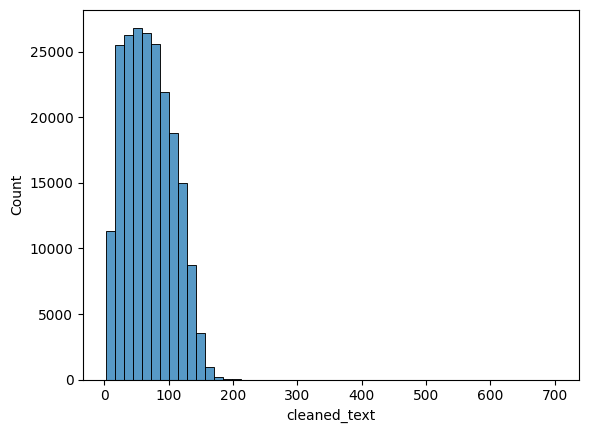

In [36]:
sns.histplot(x=df['cleaned_text'].str.len(), data=df, bins=50)
plt.show()

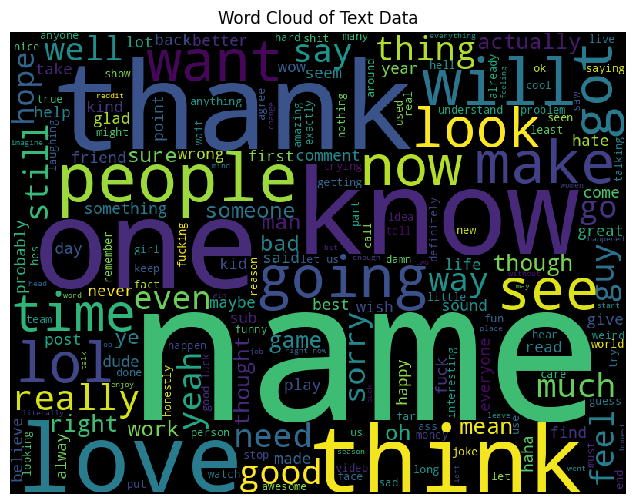

In [37]:
text = ' '.join(df['cleaned_text'].tolist())  # Combine all text for word cloud
wordcloud = WordCloud(width=800, height=600).generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='nearest')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

In [38]:
# Loading emotion labels for GoEmotions taxonomy
with open("/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset/emotions.txt", "r") as file:
    GE_taxonomy = file.read().split("\n")

for emo in GE_taxonomy:
  print(emo)

admiration
amusement
anger
annoyance
approval
caring
confusion
curiosity
desire
disappointment
disapproval
disgust
embarrassment
excitement
fear
gratitude
grief
joy
love
nervousness
optimism
pride
realization
relief
remorse
sadness
surprise
neutral


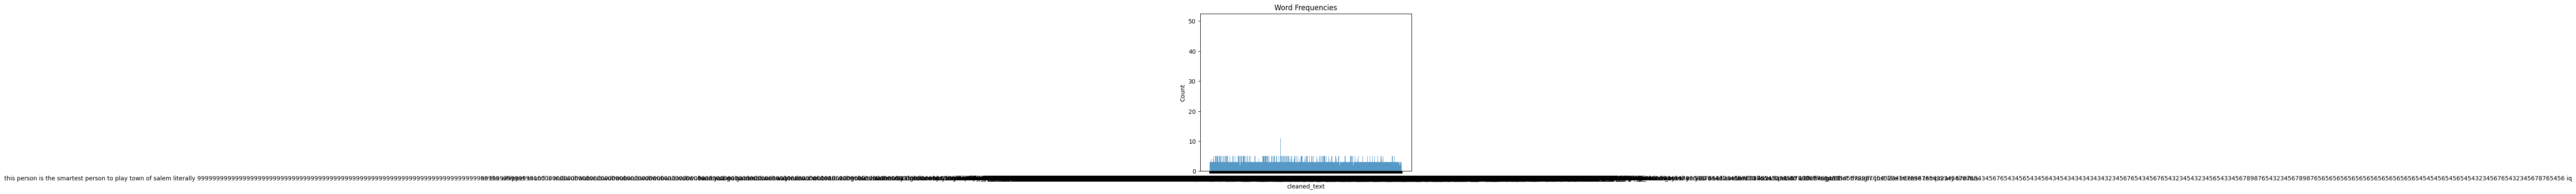

In [39]:
# Plot a histogram of the word frequencies
sns.histplot(x='cleaned_text', data=df, kde=False)
plt.title('Word Frequencies')
plt.show()

In [40]:
# # Function to get top 10 words using TF-IDF
# def plot_top_words_barchart(comments, axes):
#     # Initialize the TF-IDF Vectorizer
#     tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10)

#     # Fit and transform the cleaned text data
#     tfidf_matrix = tfidf_vectorizer.fit_transform(comments)

#     # Get feature names (words) and their scores
#     feature_names = tfidf_vectorizer.get_feature_names_out()
#     tfidf_scores = tfidf_matrix.sum(axis=0).A1

#     # Create a dictionary of words and their corresponding TF-IDF scores
#     word_scores = dict(zip(feature_names, tfidf_scores))

#     # Sort the words by their TF-IDF scores in descending order
#     sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

#     # Get the top 10 words and their scores
#     top_words = sorted_words[:10]

#     # Separate words and their scores for plotting
#     words, scores = zip(*top_words)

#     # Plot the top 10 words and their TF-IDF scores
#     sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
#     axes.set_title('Top 10 Words by TF-IDF')

# # Create a plot
# fig, axes = plt.subplots(7, 4, figsize=(25, 30))
# fig.suptitle('10 most frequent words for each emotion', fontweight="bold", fontsize=20)

# # Loop through each emotion and plot the top words
# for i, axi in enumerate(axes.flat):
#     if i < len(GE_taxonomy):
#         emotion = GE_taxonomy[i]
#         plot_top_words_barchart(df.loc[df['emotion'] == emotion, "cleaned_text"], axi)
#         axi.set_title(emotion, fontweight="bold")

# plt.tight_layout()
# fig.subplots_adjust(top=0.95)
# plt.show()


In [41]:
# from matplotlib.backends.backend_pdf import PdfPages

# # Specify the full path to the folder where you want to save the PDF file
# folder_path = "/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/"

# # Create a PDF file to save the plots
# pdf_filename = "top_10words_plots.pdf"
# pdf_filepath = folder_path + pdf_filename
# pdf_pages = PdfPages(pdf_filepath)

# # Save the plot to the PDF file
# pdf_pages.savefig(fig)
# plt.close(fig)

# # Close the PDF file
# pdf_pages.close()

# print(f"Plots saved to {pdf_filepath}.")

In [42]:
# def plot_top_words_barchart(comments, axes, num_words=10):
#     # Initialize the TF-IDF Vectorizer
#     tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=num_words)

#     # Fit and transform the cleaned text data
#     tfidf_matrix = tfidf_vectorizer.fit_transform(comments)

#     # Get feature names (words) and their scores
#     feature_names = tfidf_vectorizer.get_feature_names_out()
#     tfidf_scores = tfidf_matrix.sum(axis=0).A1

#     # Create a dictionary of words and their corresponding TF-IDF scores
#     word_scores = dict(zip(feature_names, tfidf_scores))

#     # Sort the words by their TF-IDF scores in descending order
#     sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

#     # Get the top words and their scores
#     top_words = sorted_words[:num_words]

#     # Separate words and their scores for plotting
#     words, scores = zip(*top_words)

#     # Plot the top words and their TF-IDF scores
#     sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
#     axes.set_title(f'Top {num_words} Words by TF-IDF')

#     # Add text annotations for the top words and their scores
#     for i, (word, score) in enumerate(top_words):
#         axes.text(score, i, f' {score:.4f}', va='center', ha='left', color='black', fontweight='bold')

# def generate_plots(df, GE_taxonomy, num_words=10, output_file='top_words_plots.pdf'):
#     # Create a PDF file to save the plots
#     folder_path = "/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/"
#     pdf_filepath = os.path.join(folder_path, output_file)
#     pdf_pages = PdfPages(pdf_filepath)

#     # Create a plot
#     fig, axes = plt.subplots(7, 4, figsize=(25, 30))
#     fig.suptitle(f'Top {num_words} most frequent words for each emotion', fontweight="bold", fontsize=20)

#     # Loop through each emotion and plot the top words
#     for i, axi in enumerate(axes.flat):
#         if i < len(GE_taxonomy):
#             emotion = GE_taxonomy[i]
#             print(f"\nEmotion: {emotion}")
#             plot_top_words_barchart(df.loc[df[emotion] == 1, "cleaned_text"], axi, num_words)
#             axi.set_title(emotion, fontweight="bold")

#     plt.tight_layout()
#     fig.subplots_adjust(top=0.95)

#     # Save the plot to the PDF file
#     pdf_pages.savefig(fig)
#     plt.close(fig)

#     # Close the PDF file
#     pdf_pages.close()

#     print(f"Plots saved to {pdf_filepath}.")

In [43]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_top_words_barchart(comments, axes, num_words=10):
    # Initialize the TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=num_words)

    # Fit and transform the cleaned text data
    tfidf_matrix = tfidf_vectorizer.fit_transform(comments)

    # Get feature names (words) and their scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1

    # Create a dictionary of words and their corresponding TF-IDF scores
    word_scores = dict(zip(feature_names, tfidf_scores))

    # Sort the words by their TF-IDF scores in descending order
    sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

    # Get the top words and their scores
    top_words = sorted_words[:num_words]

    # Separate words and their scores for plotting
    words, scores = zip(*top_words)

    # Plot the top words and their TF-IDF scores
    sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
    axes.set_title(f'Top {num_words} Words by TF-IDF')

def generate_plots(df, GE_taxonomy, num_words=10, output_file='top_words_plots.pdf'):
    # Create a PDF file to save the plots
    folder_path = "/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/"
    pdf_filepath = os.path.join(folder_path, output_file)
    pdf_pages = PdfPages(pdf_filepath)

    # Create a plot
    fig, axes = plt.subplots(7, 4, figsize=(25, 30))
    fig.suptitle(f'Top {num_words} most frequent words for each emotion', fontweight="bold", fontsize=20)

    # Loop through each emotion and plot the top words
    for i, axi in enumerate(axes.flat):
        if i < len(GE_taxonomy):
            emotion = GE_taxonomy[i]
            plot_top_words_barchart(df.loc[df[emotion] == 1, "cleaned_text"], axi, num_words)
            axi.set_title(emotion, fontweight="bold")

    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

    # Save the plot to the PDF file
    pdf_pages.savefig(fig)
    plt.close(fig)

    # Close the PDF file
    pdf_pages.close()

    print(f"Plots saved to {pdf_filepath}.")



<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `

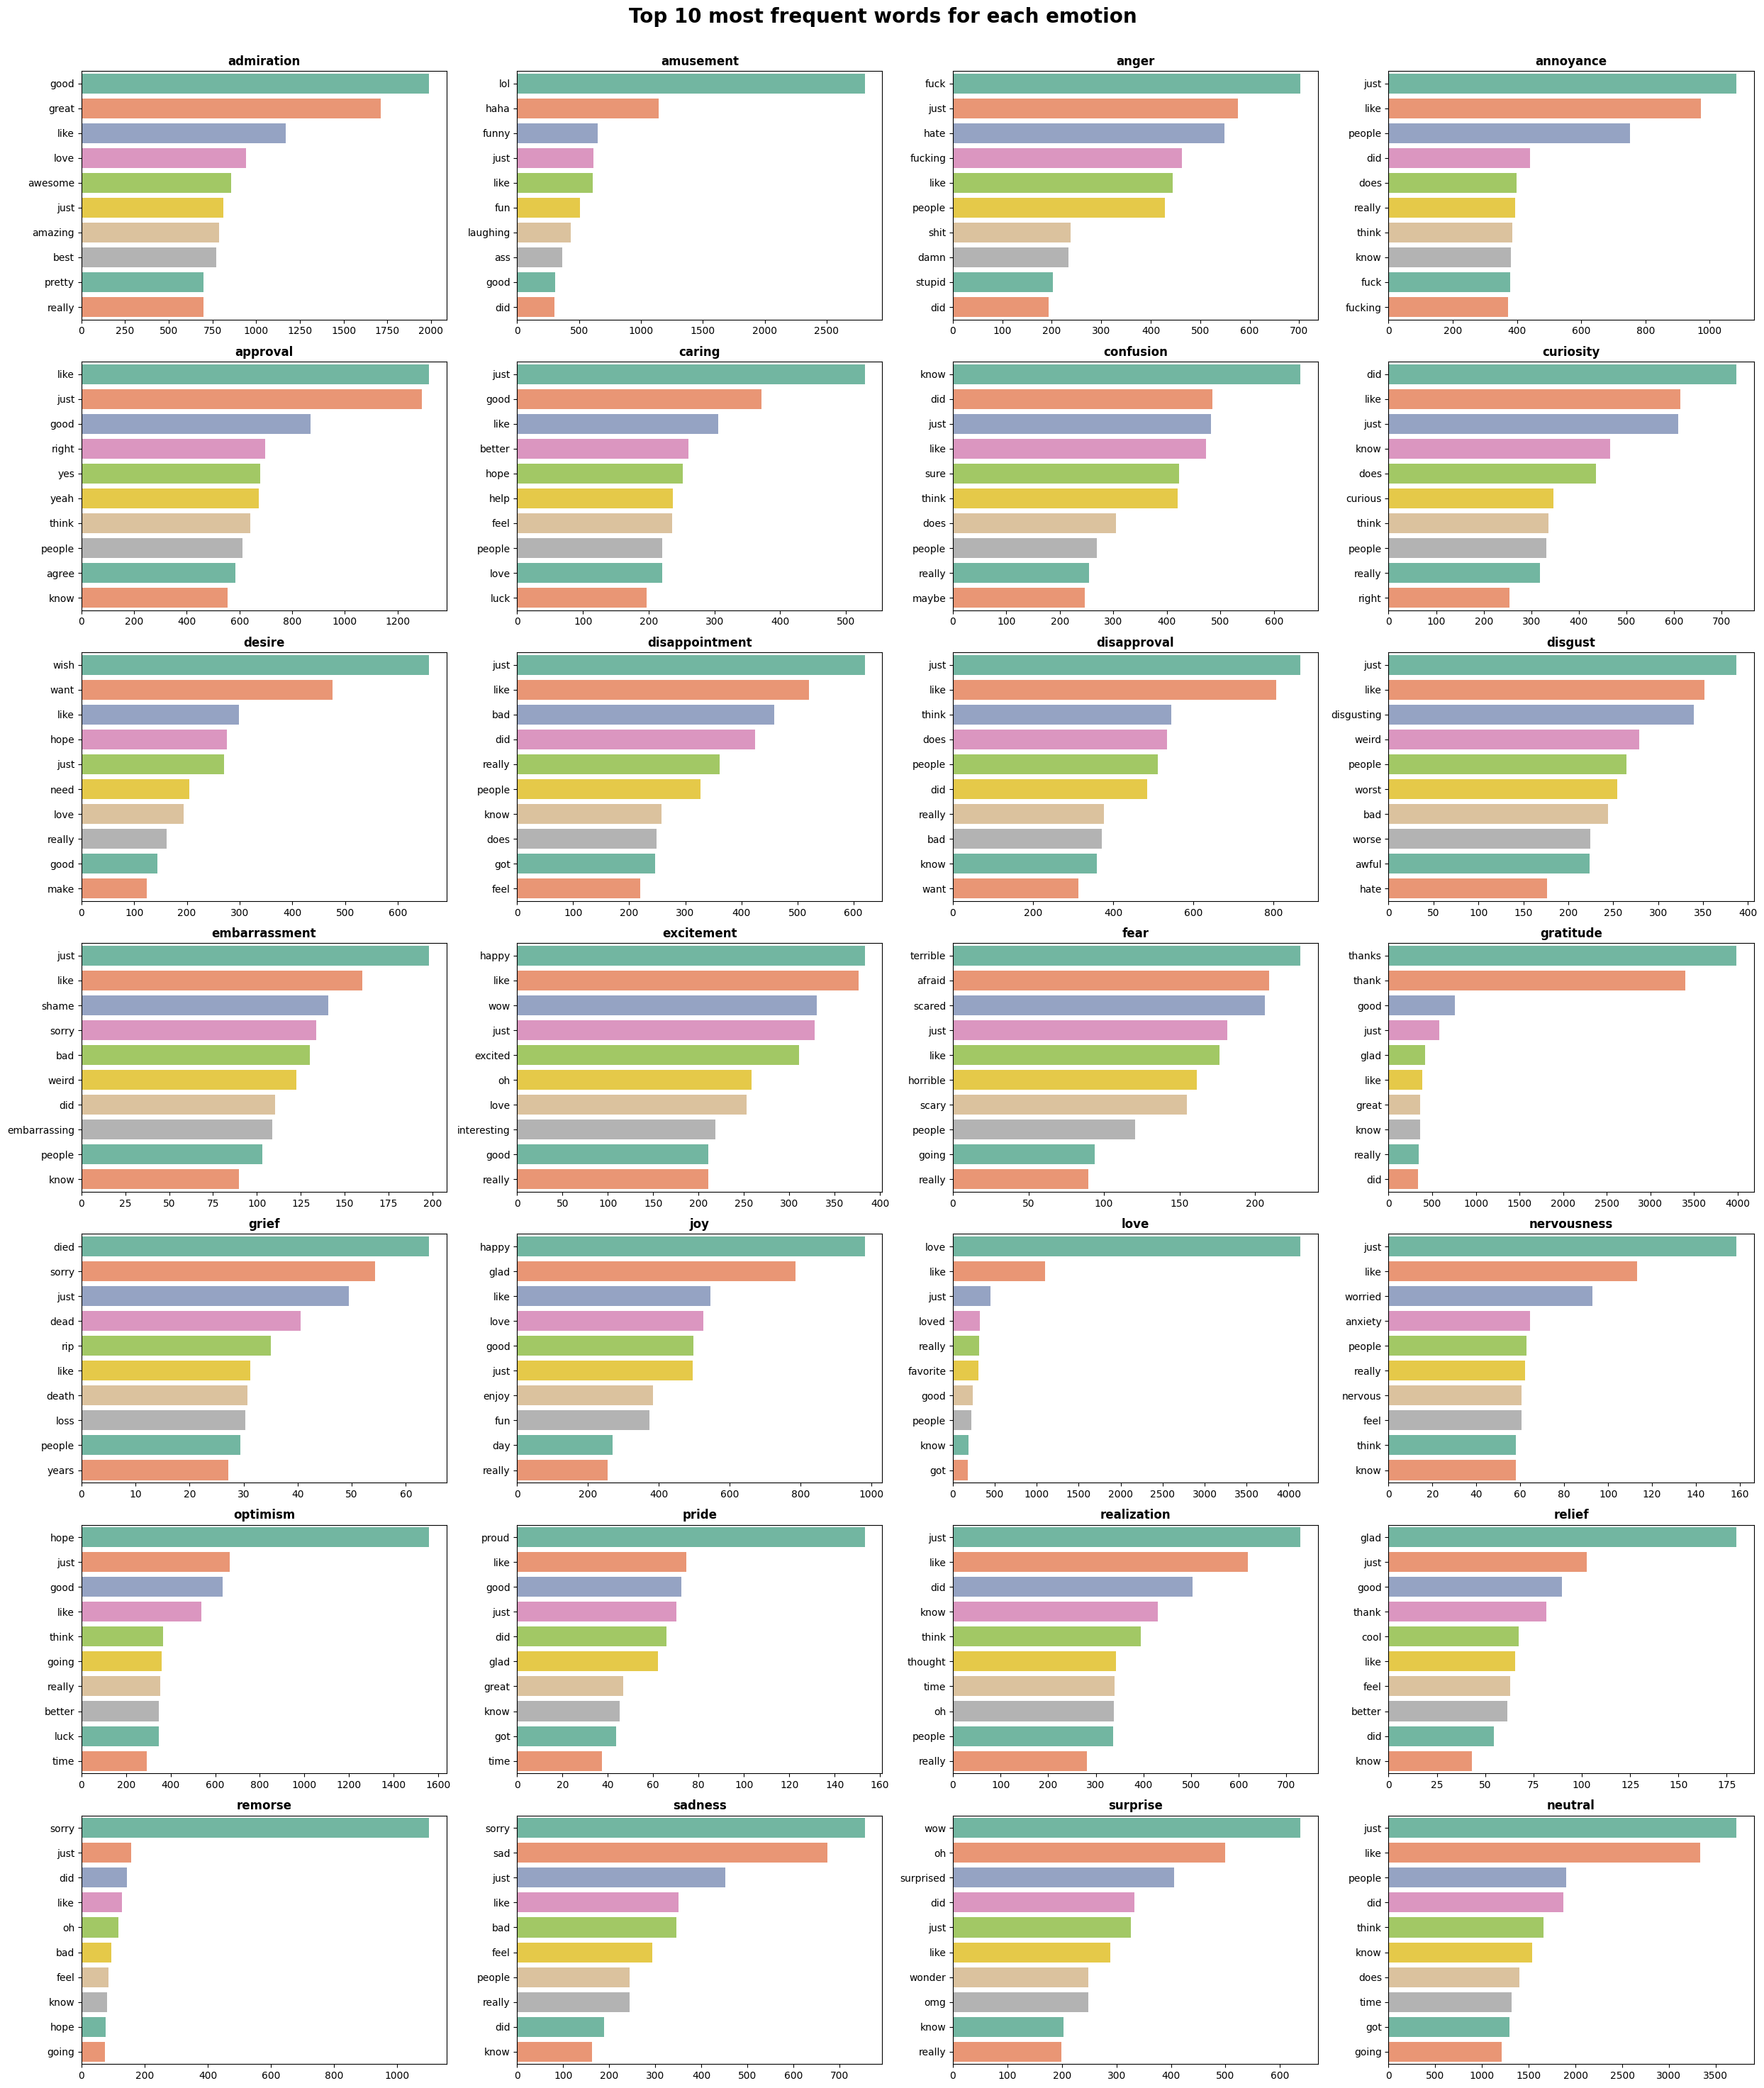

Plots saved to /content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/top_10_words_plots.pdf.


<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `

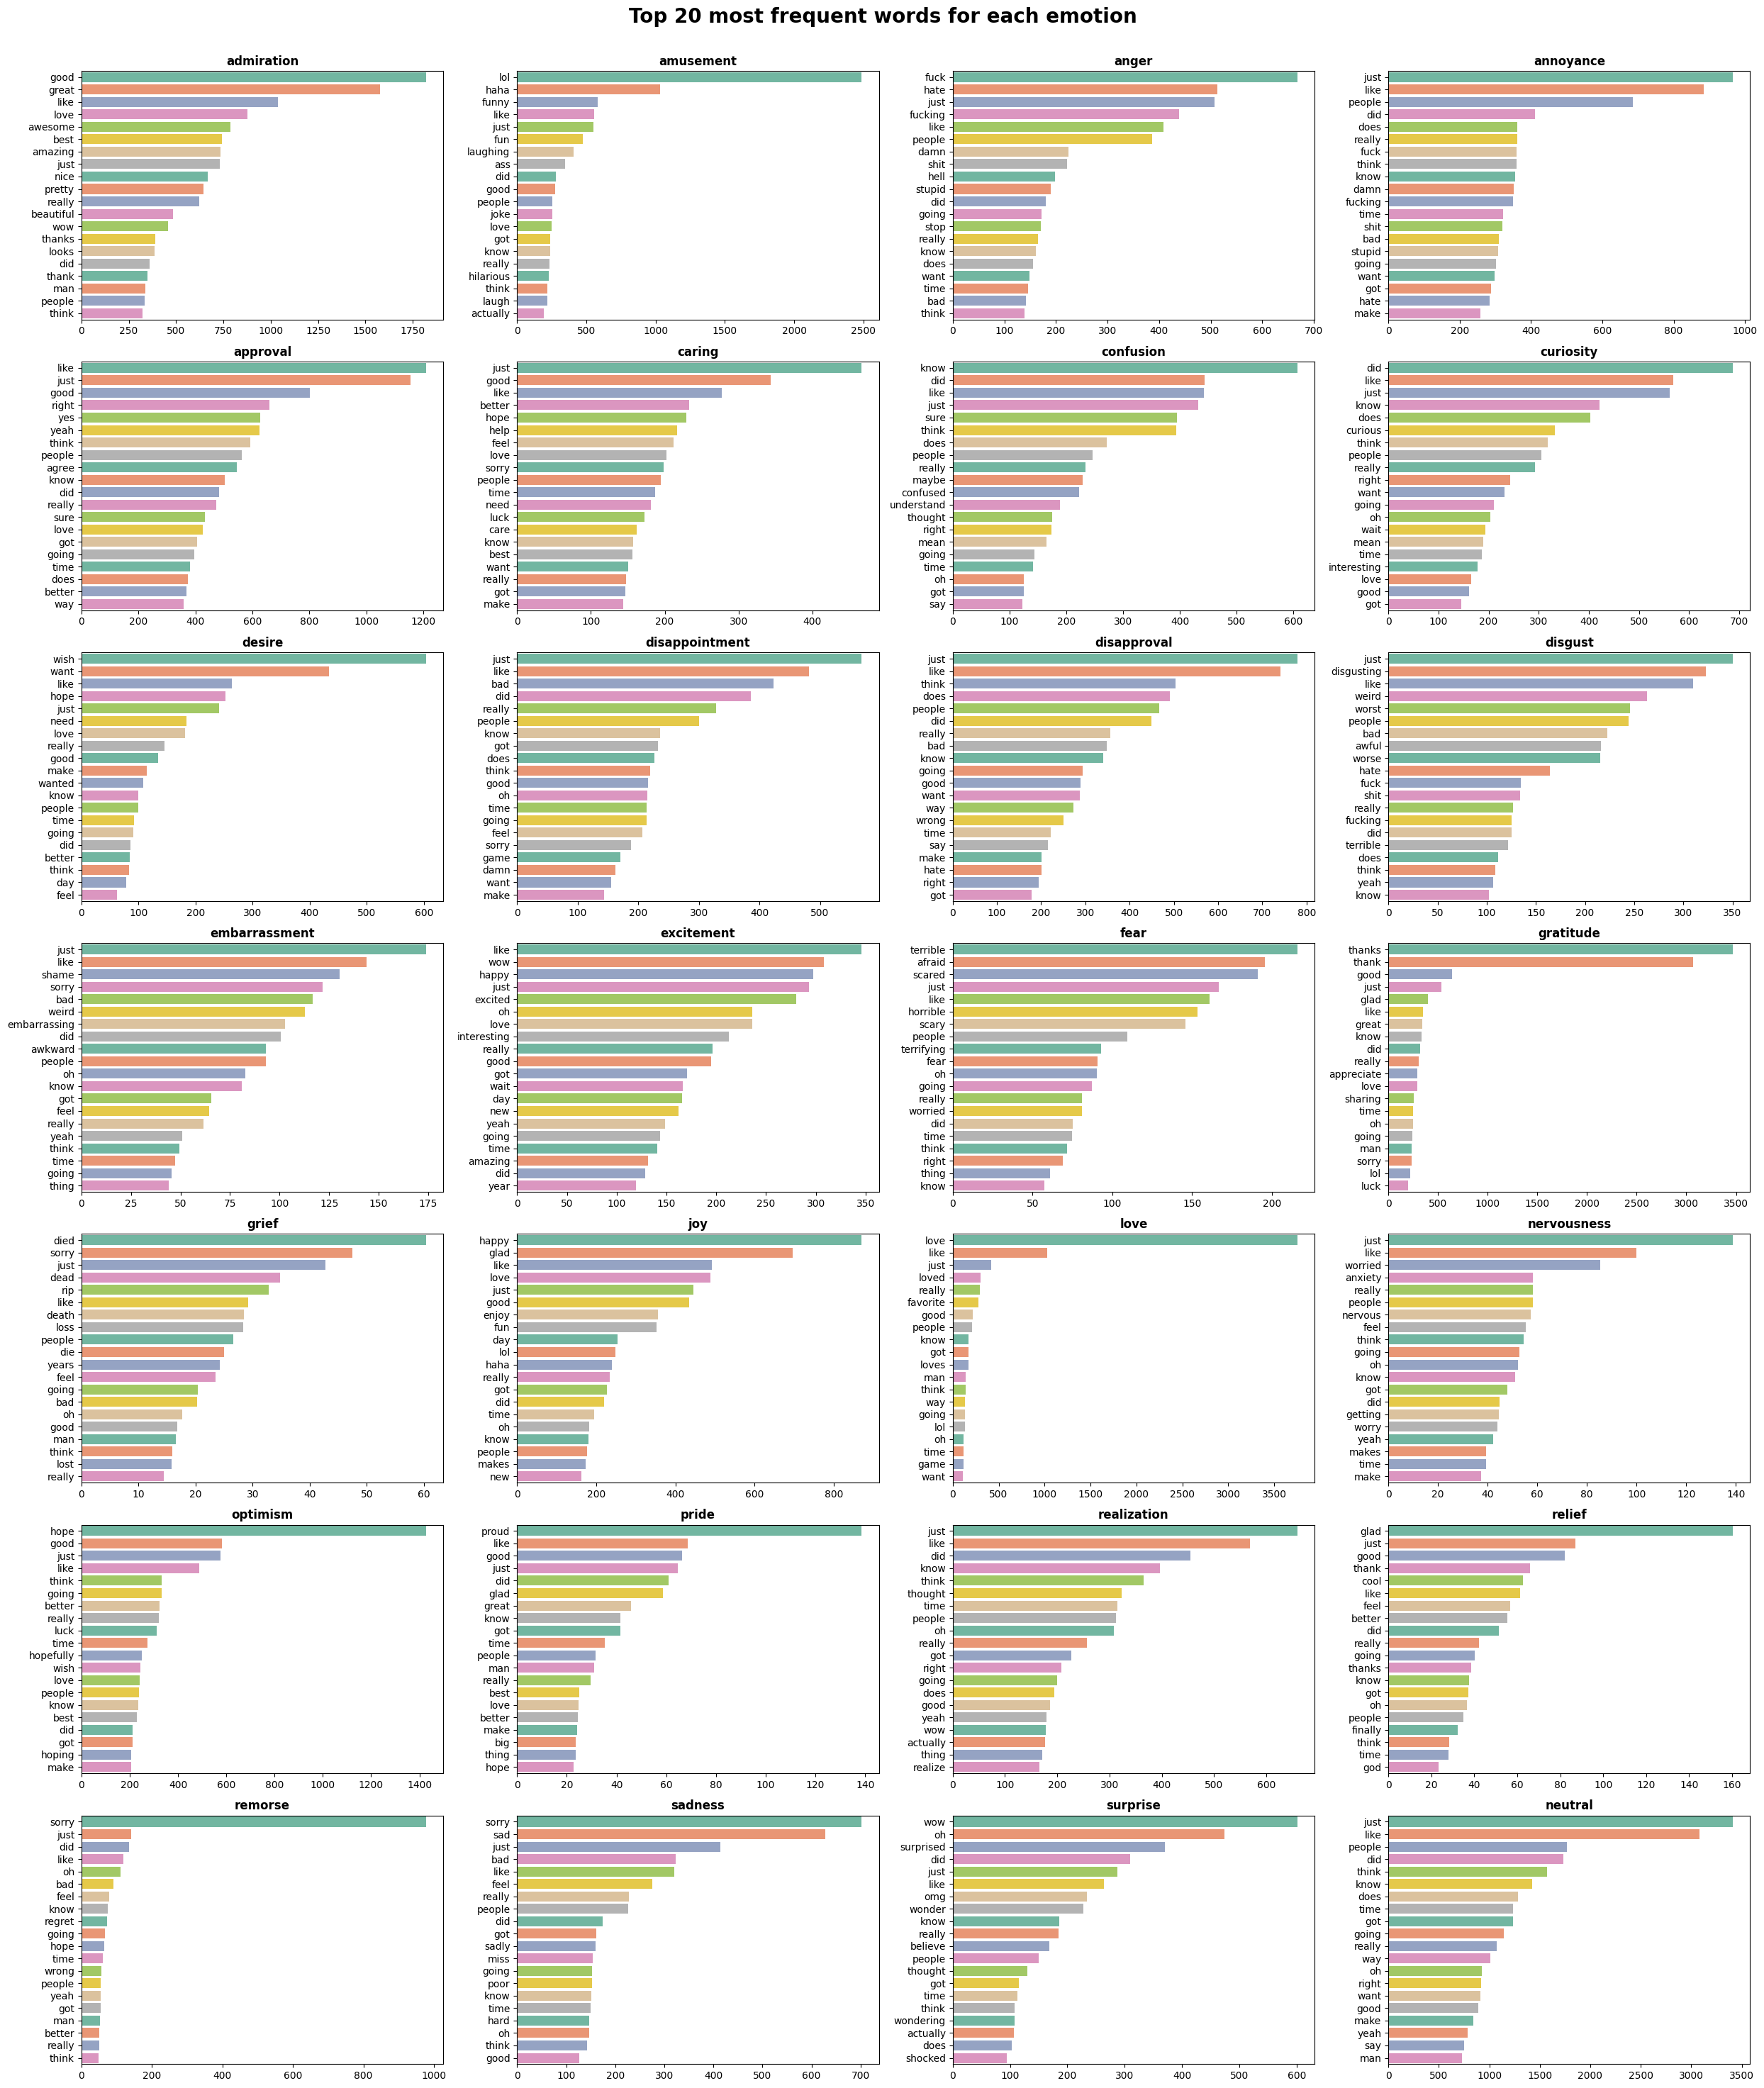

Plots saved to /content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/top_20_words_plots.pdf.


<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=axes, palette="Set2")
<ipython-input-43-94a76d4c07d2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `

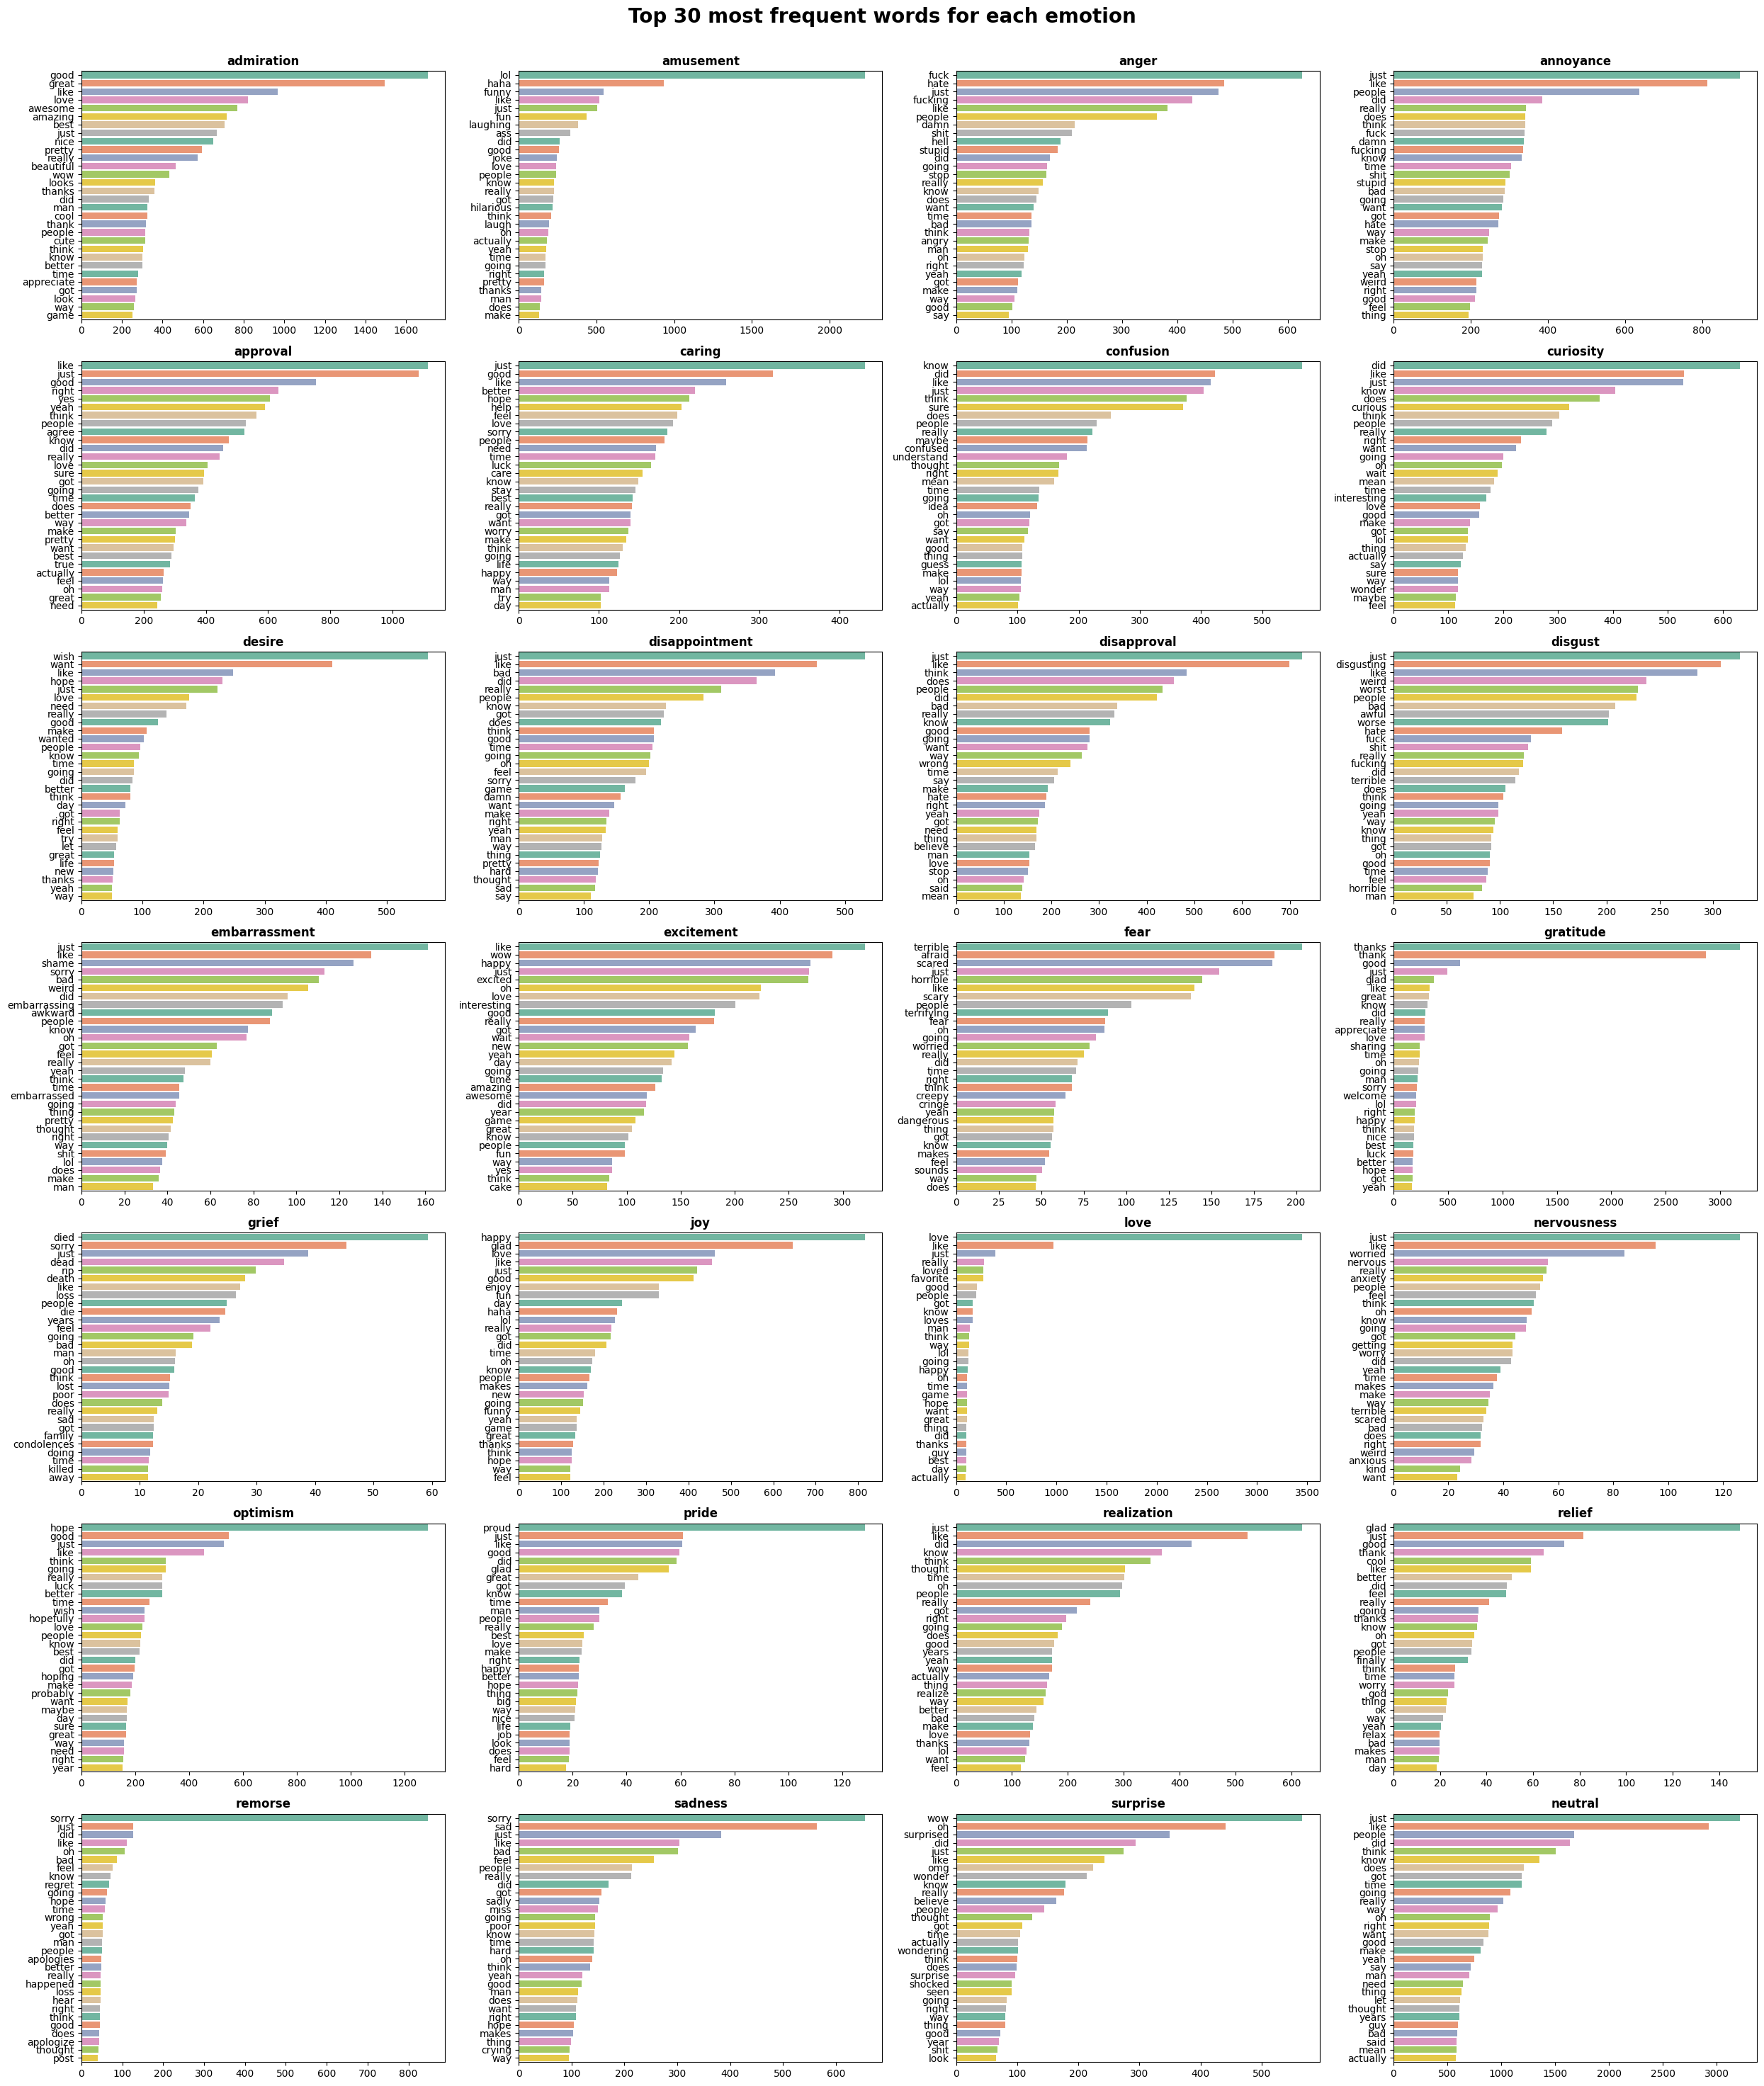

Plots saved to /content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/top_30_words_plots.pdf.


In [44]:
# Assuming df DataFrame and GE_taxonomy is a list of your emotion columns
generate_plots(df, GE_taxonomy, num_words=10, output_file='top_10_words_plots.pdf')
generate_plots(df, GE_taxonomy, num_words=20, output_file='top_20_words_plots.pdf')
generate_plots(df, GE_taxonomy, num_words=30, output_file='top_30_words_plots.pdf')

In [45]:
output_dir = '/content/drive/MyDrive/Colab Notebooks/Thesis_Work/Thesis-II/DataFiles/full_dataset'
train_dataset_path = output_dir + '/train_dataset.csv'
validation_dataset_path = output_dir + '/validation_dataset.csv'
test_dataset_path = output_dir + '/test_dataset.csv'


# First, split the data into 70% training and 30% for the combined validation and test sets
train, test_temp = train_test_split(df, test_size=0.30, shuffle=True, random_state=42)

# Then, split the 30% data into 15% validation and 15% test sets
validation, test = train_test_split(test_temp, test_size=0.50, shuffle=True, random_state=42)

# Saving datasets for modeling
train.to_csv(train_dataset_path, index=False)
validation.to_csv(validation_dataset_path, index=False)
test.to_csv(test_dataset_path, index=False)

In [46]:
df

,cleaned_text,emotion,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,that game hurt.,sadness,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,sexuality should not be a grouping category i...,admiration,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"you do right, if you do not care then fuck them!",neutral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,man i love reddit.,love,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"name was nowhere near them, he was by the falc...",neutral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,everyone likes name.,love,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
211221,well when you have imported about a gazillion ...,caring,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
211222,that looks amazing,admiration,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211223,the fda has plenty to criticize. but like here...,anger,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
